In [1]:
# Celda 1 - Imports y carga de datos

import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

BASE_DIR = Path("..")
PROCESSED_DIR = BASE_DIR / "processed"

clean_path = PROCESSED_DIR / "suelos_clean.csv"
print("📂 Cargando datos desde:", clean_path.resolve())

df = pd.read_csv(clean_path)
print("Dimensiones del dataset:", df.shape)
df.head()


📂 Cargando datos desde: D:\ICD-SOIL\processed\suelos_clean.csv
Dimensiones del dataset: (35111, 40)


C:\Users\diego\AppData\Local\Temp\ipykernel_33380\480778758.py:22: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(clean_path)


,secuencial,fecha_de_an_lisis,departamento,municipio,cultivo,estado,tiempo_de_establecimiento,topografia,drenaje,riego,...,manganeso_disponible_doble_acido,zinc_disponible_doble_acido,acidez_intercambiable,cic,hierro_olsen,manganeso_olsen,zinc_olsen,hierro_doble_acido,manganeso_doble_acido,zinc_doble_acido
0,1,2014-07-01,NARIÑO,SAN ANDRÉS DE TUMACO,No Indica,No indica,No indica,No indica,No indica,No indica,...,ND,ND,NaN,2.094,66.39,1.700,1.500,NaN,NaN,NaN
1,164,2014-05-09,CUNDINAMARCA,UNE,Lulo,Establecido,De 0 a 1 año,Plano,Buen drenaje,Aspersión,...,ND,ND,NaN,11.490,222.00,3.599,2.500,NaN,NaN,NaN
2,165,2014-05-09,CUNDINAMARCA,UNE,Lulo,Establecido,De 0 a 1 año,Ondulado,Buen drenaje,Aspersión,...,ND,ND,NaN,12.660,345.00,3.900,7.000,NaN,NaN,NaN
3,166,2014-05-09,CUNDINAMARCA,FUNZA,Guisantes,Por establecer,No indica,Plano,Buen drenaje,Goteo,...,ND,ND,NaN,7.303,102.00,3.599,7.500,NaN,NaN,NaN
4,167,2014-05-09,VALLE DEL CAUCA,LA UNIÓN,Guanábana,Establecido,Mas de 10 años,Plano,Buen drenaje,Manguera,...,ND,ND,NaN,22.770,8.10,0.800,1.799,NaN,NaN,NaN


In [2]:
# Celda 2 - Filtrado de variables de interés y chequeo mínimo de datos

VARIABLES_SUELO = [
    "ph_agua_suelo","materia_organica","fosforo_bray_ii","azufre_fosfato_monocalcico",
    "acidez_intercambiable","aluminio_intercambiable","calcio_intercambiable",
    "magnesio_intercambiable","potasio_intercambiable","sodio_intercambiable",
    "cic","conductividad_electrica","hierro_olsen","cobre_disponible","manganeso_olsen",
    "zinc_olsen","boro_disponible","hierro_doble_acido","cobre_doble_acido",
    "manganeso_doble_acido","zinc_doble_acido"
]

variables_presentes = [v for v in VARIABLES_SUELO if v in df.columns]

# Filtrar variables con al menos el 5% de cobertura (evita usar columnas casi vacías)
vars_for_model = [
    v for v in variables_presentes
    if df[v].notna().mean() >= 0.05
]

print(f"Variables usadas en el modelo ({len(vars_for_model)}):")
vars_for_model


Variables usadas en el modelo (17):


['ph_agua_suelo',
 'materia_organica',
 'fosforo_bray_ii',
 'azufre_fosfato_monocalcico',
 'acidez_intercambiable',
 'aluminio_intercambiable',
 'calcio_intercambiable',
 'magnesio_intercambiable',
 'potasio_intercambiable',
 'sodio_intercambiable',
 'cic',
 'conductividad_electrica',
 'hierro_olsen',
 'cobre_disponible',
 'manganeso_olsen',
 'zinc_olsen',
 'boro_disponible']

In [3]:
# Celda 3 - Imputación y escalado

X = df[vars_for_model].copy()

imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

print("Shape X scaled:", X_scaled.shape)


Shape X scaled: (35111, 17)


In [4]:
# Celda 4 - Entrenamiento de modelos de detección

# Modelo 1: Isolation Forest
iso = IsolationForest(
    n_estimators=200,
    contamination="auto",
    random_state=42
)
iso.fit(X_scaled)
raw_iso = -iso.decision_function(X_scaled)

# Modelo 2: Local Outlier Factor
lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination="auto"
)
raw_lof = -lof.fit_predict(X_scaled)  # score basados en densidad

# Normalización 0-1
def normalize(x):
    return (x - x.min()) / (x.max() - x.min() + 1e-8)

df["iso_score"] = normalize(raw_iso)
df["lof_score"] = normalize(raw_lof.clip(min=0))  # evita negativos

df[["iso_score", "lof_score"]].head()


,iso_score,lof_score
0,0.040404,0.0
1,0.040200,0.0
2,0.182721,0.0
3,0.096554,0.0
4,0.331227,0.0


In [5]:
# Celda 5 - Score final combinado

df["anom_score_global"] = (df["iso_score"] + df["lof_score"]) / 2

# Etiqueta outlier
threshold = df["anom_score_global"].quantile(0.75)
df["is_outlier"] = (df["anom_score_global"] > threshold).astype(int)

df["anom_score_global"].describe()


count    35111.000000
mean         0.073740
std          0.110575
min          0.000000
25%          0.024392
50%          0.041736
75%          0.077457
max          1.000000
Name: anom_score_global, dtype: float64

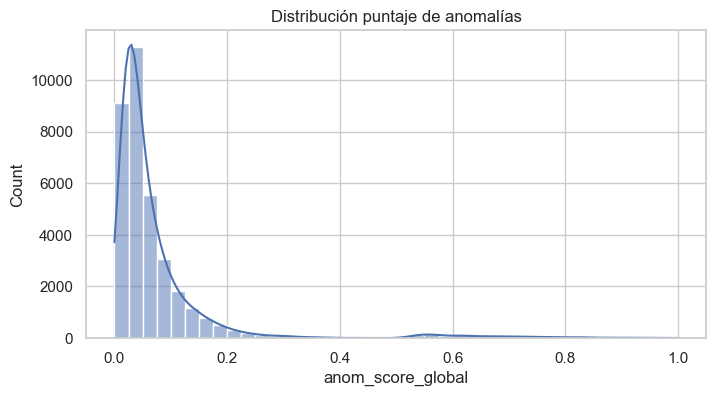

is_outlier
0    75.0
1    25.0
Name: proportion, dtype: float64


In [6]:
# Celda 6 - Distribución del score

plt.figure(figsize=(8,4))
sns.histplot(df["anom_score_global"], kde=True, bins=40)
plt.title("Distribución puntaje de anomalías")
plt.show()

# Conteo
print(df["is_outlier"].value_counts(normalize=True).mul(100).round(2))


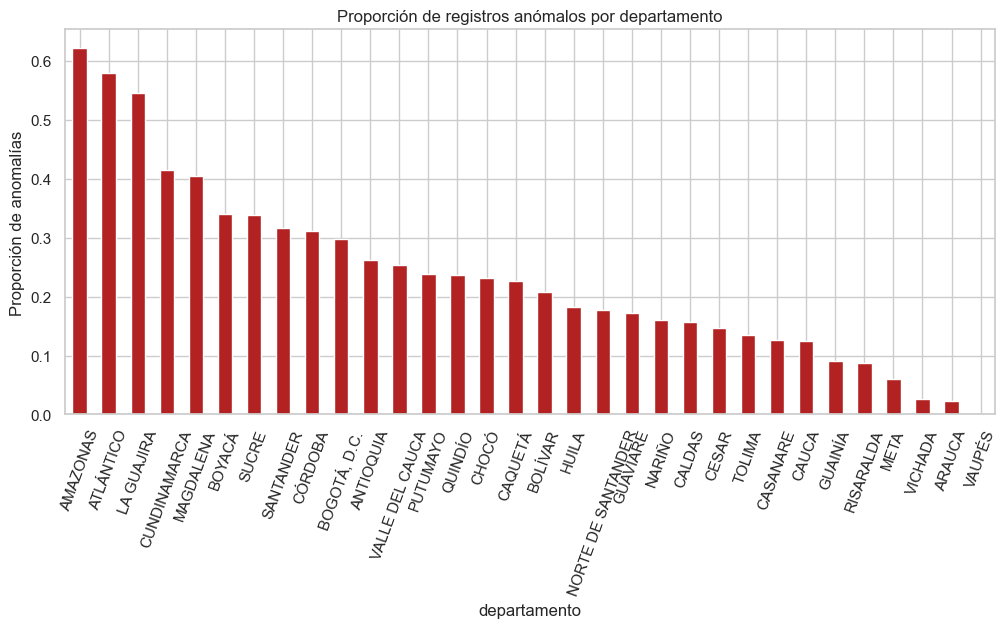

departamento
AMAZONAS        0.622222
ATLÁNTICO       0.578755
LA GUAJIRA      0.545455
CUNDINAMARCA    0.415378
MAGDALENA       0.405303
Name: is_outlier, dtype: float64

In [7]:
# Celda 7 - Análisis territorial

group_col = "dep_norm" if "dep_norm" in df.columns else "departamento"

outliers_depto = (
    df.groupby(group_col)["is_outlier"]
      .mean()
      .sort_values(ascending=False)
)

plt.figure(figsize=(12,5))
outliers_depto.plot(kind="bar", color="firebrick")
plt.ylabel("Proporción de anomalías")
plt.title(f"Proporción de registros anómalos por {group_col}")
plt.xticks(rotation=70)
plt.show()

outliers_depto.head()


In [8]:
# Celda 8 - Importancia por variable (feature impact)

importances = np.abs(scaler.mean_)  # aproximación simple
impact_df = pd.DataFrame({"variable": vars_for_model, "impacto_estimado": importances})
impact_df.sort_values("impacto_estimado", ascending=False)


,variable,impacto_estimado
12,hierro_olsen,222.510327
2,fosforo_bray_ii,29.015988
3,azufre_fosfato_monocalcico,13.798925
10,cic,10.901059
14,manganeso_olsen,7.622113
6,calcio_intercambiable,7.317805
0,ph_agua_suelo,5.723810
1,materia_organica,4.235338
15,zinc_olsen,4.150443
13,cobre_disponible,3.475796


In [9]:
# Celda 9 - Guardar archivo final con anomalías

output_path = PROCESSED_DIR / "suelos_anomalias.csv"
df.to_csv(output_path, index=False)

print("💾 Archivo guardado:", output_path.resolve())


💾 Archivo guardado: D:\ICD-SOIL\processed\suelos_anomalias.csv
